# 基于backtrader多因子策略框架的优化

In [1]:
import sqlite3
import pandas as pd  
import talib
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import akshare as ak
import numpy as np
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [88]:
import streamlit as st

st.__version__

'1.20.0'

## 多因子交易策略框架

### 通用多股策略

In [2]:
conn=sqlite3.connect(r'F:\量化金融\stock_2018.db')

In [3]:
stock_daily=pd.read_sql("select * from stock_daily where 股票代码>'003000.SZ'",con=conn)

In [4]:
stock_daily.columns

Index(['index', '交易日期', '股票代码', '股票简称', '开盘价', '最高价', '最低价', '收盘价', '成交量(手)',
       '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
       '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
       '总市值(万元)', '流通市值(万元)'],
      dtype='object')

In [4]:
stock_daily.columns=['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close', 'volume',
       '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
       '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
       '总市值(万元)', '流通市值(万元)']
stock_daily["date"]=stock_daily["date"].astype("str").astype("datetime64")
stock_daily.set_index("date",inplace=True,drop=False)
stock_daily["openinterest"]=0
n1=len(stock_daily.date.unique())
z1=pd.Series(range(0,n1),index=stock_daily.date.unique()).sort_index()

In [5]:
def get_data_1(syboml):
    stock=stock_daily[stock_daily["股票代码"]==syboml][["open","high","low","close","volume","openinterest"]]
    stock=pd.concat([stock,z1],axis=1).fillna(method="bfill").fillna(method="ffill")
    return stock[["open","high","low","close","volume","openinterest"]]

In [6]:
class my_strategy_date_2(bt.Strategy):
    #全局设定交易策略的参数

    def __init__(self):
        # 初始化交易指令、买卖价格和手续费
        self.order = None

    def next(self):
        # 检查是否持仓 
        #print(str(self.datetime.date(0)))
        cash_value.update({str(self.datetime.date(0)):self.broker.getvalue()})
        if str(self.datetime.date(0)) in sell_date.keys(): # 没有持仓
            s_list=sell_date[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0,data=i)
        if str(self.datetime.date(0)) in buy_date.keys(): # 没有持仓
            s_list=buy_date[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0.9/len(s_list),data=i)
                

            
    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0) # 拿现在的日期
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(f"""买入{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            elif order.issell():
                self.log(f"""卖出{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

#这是读入一个股票数据的策略，请改写为多个股票读入
def huice_run_num(start,end,stock_list,strategy):

    cerebro = bt.Cerebro()
    for i in stock_list:
        stock=get_data_1(i)
        data = bt.feeds.PandasData(dataname=stock,fromdate=start,todate=end)           
        cerebro.adddata(data,name=i) 
        
    cerebro.addstrategy(strategy) 
    cerebro.broker.setcash(100000) 
    cerebro.broker.setcommission(commission=0.002) 


    print(start.date(),end.date())
    print('初始资金: %.2f' % cerebro.broker.getvalue())
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')
    results = cerebro.run()
    strat = results[0]
    print('最终资金: %.2f' % cerebro.broker.getvalue())
    print('夏普比率:', strat.analyzers.SharpeRatio.get_analysis())
    print('回撤指标:', strat.analyzers.DW.get_analysis())
    
    return cerebro

In [7]:
start=datetime(2018,2,22)
end=datetime(2023,2,10)
stock_list=["003002.SZ","003003.SZ","300001.SZ"]
buy_date={"2020-09-22":["003002.SZ","003003.SZ"]}
sell_date={"2023-02-02":["003002.SZ","003003.SZ"]}

In [8]:
cash_value={}
result=huice_run_num(start,end,stock_list,my_strategy_date_2)

2018-02-22 2023-02-10
初始资金: 100000.00
2020-09-23, 买入003002.SZ, 成交量3800，成交价13.02
2020-09-23, 买入003003.SZ, 成交量2707，成交价18.28
2023-02-03, 卖出003002.SZ, 成交量-3800，成交价20.89
2023-02-03, 卖出003003.SZ, 成交量-2707，成交价12.09
最终资金: 112731.75
夏普比率: OrderedDict([('sharperatio', 0.13880099293497766)])
回撤指标: AutoOrderedDict([('len', 58), ('drawdown', 8.111117263713433), ('moneydown', 9950.936514), ('max', AutoOrderedDict([('len', 455), ('drawdown', 47.599755296618), ('moneydown', 56371.585799999986)]))])


In [48]:
cash_value=pd.Series(cash_value)

<AxesSubplot:>

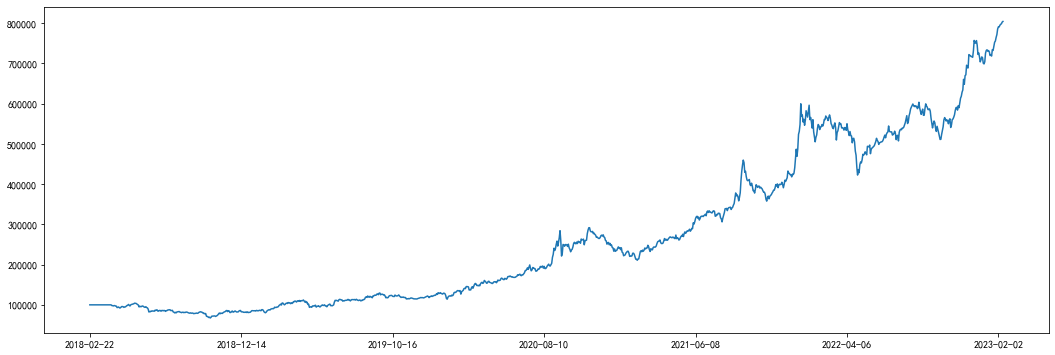

In [49]:
cash_value.plot(figsize=(18,6))

### 基于排序的多因子交易方案的构建函数

In [9]:
time_id=pd.Series(stock_daily.date.unique()).sort_values().tolist()[::30]

In [79]:
time_id[20]

Timestamp('2020-06-23 00:00:00')

In [10]:
buy_date={}
sell_date={}
postion=set([])
stock_list=set([])
for i in time_id:
    
    factor1_stock=stock_daily[stock_daily["date"]==i].sort_values(by='换手率(%)',ascending=True)["股票代码"].tolist()
    factor2_stock=stock_daily[stock_daily["date"]==i].sort_values(by='volume',ascending=True)["股票代码"].tolist()
    f_1_df=pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)
    f_2_df=pd.Series(range(1,len(factor2_stock)+1),index=factor2_stock)
    f_1_2=pd.concat([f_1_df,f_2_df],axis=1)
    f_1_2[2]=f_1_2[0]+f_1_2[1]
    
    buy_list=f_1_2.sort_values(by=2).head(5).index.tolist()
    buy_date.update({str(i.date()):buy_list})
    sell_date.update({str(i.date()):list(postion-set(buy_list))})
    postion=set(buy_list)
    stock_list=stock_list|postion

In [11]:
start=datetime(2018,2,22)
end=datetime(2023,2,10)
cash_value={}
result=huice_run_num(start,end,stock_list,my_strategy_date_2)

2018-02-22 2023-02-10
初始资金: 100000.00
2018-04-04, 买入300504.SZ, 成交量790，成交价25.04
2018-04-04, 买入300634.SZ, 成交量895，成交价22.12
2018-04-04, 买入300125.SZ, 成交量349，成交价51.52
2018-04-04, 买入300042.SZ, 成交量339，成交价52.58
2018-04-04, 买入300180.SZ, 成交量306，成交价59.40
2018-05-22, 卖出300042.SZ, 成交量-339，成交价49.72
2018-05-22, 卖出300125.SZ, 成交量-349，成交价59.63
2018-05-22, 卖出300504.SZ, 成交量-790，成交价55.00
2018-05-22, 卖出300634.SZ, 成交量-895，成交价60.19
2018-05-22, 买入300454.SZ, 成交量488，成交价63.39
2018-05-22, 买入300180.SZ, 成交量167，成交价59.66
2018-05-22, 买入300416.SZ, 成交量556，成交价50.97
2018-05-22, 买入300057.SZ, 成交量1589，成交价17.90
2018-05-22, 买入300342.SZ, 成交量496，成交价57.06
2018-07-04, 卖出300454.SZ, 成交量-488，成交价114.88
2018-07-04, 卖出300342.SZ, 成交量-496，成交价51.29
2018-07-04, 卖出300057.SZ, 成交量-1589，成交价13.03
2018-07-04, 卖出300180.SZ, 成交量-473，成交价50.88
2018-07-04, 卖出300416.SZ, 成交量-556，成交价40.74
2018-07-04, 买入300747.SZ, 成交量304，成交价106.96
2018-07-04, 买入300028.SZ, 成交量6601，成交价4.03
2018-07-04, 买入300266.SZ, 成交量143，成交价185.49
2018-07-04, 买入300090.SZ, 成交量603，成交价44.21
2018-

2021-02-02, 卖出003026.SZ, 成交量-26831，成交价86.00
2021-02-02, 卖出300550.SZ, 成交量-14173，成交价37.56
2021-02-02, 卖出003025.SZ, 成交量-10843，成交价32.70
2021-02-02, 买入300695.SZ, 成交量4373，成交价62.90
2021-02-02, 买入003036.SZ, 成交量79814，成交价10.97
2021-02-02, 买入300321.SZ, 成交量22283，成交价36.20
2021-02-02, 买入300069.SZ, 成交量30159，成交价26.16
2021-02-02, 买入300649.SZ, 成交量14874，成交价25.62
2021-03-23, 卖出300321.SZ, 成交量-22283，成交价38.38
2021-03-23, 卖出300649.SZ, 成交量-30957，成交价30.42
2021-03-23, 卖出300069.SZ, 成交量-30159，成交价28.56
2021-03-23, 卖出003036.SZ, 成交量-79814，成交价12.45
2021-03-23, 买入300550.SZ, 成交量25714，成交价33.58
2021-03-23, 买入300695.SZ, 成交量1179，成交价61.63
2021-03-23, 买入300768.SZ, 成交量22746，成交价37.20
2021-03-23, 买入300486.SZ, 成交量36696，成交价23.00
2021-03-23, 买入300521.SZ, 成交量28510，成交价29.38
2021-05-10, 卖出300486.SZ, 成交量-36696，成交价22.57
2021-05-10, 卖出300550.SZ, 成交量-25714，成交价35.61
2021-05-10, 卖出300768.SZ, 成交量-22746，成交价35.27
2021-05-10, 卖出300521.SZ, 成交量-28510，成交价36.37
2021-05-10, 买入300695.SZ, 成交量1635，成交价55.42
2021-05-10, 买入300069.SZ, 成交量32780，成交价26.14
202

## 交易方案构建函数的优化

### 处理停牌与涨跌停板

在两个部分都可以处理

* 策略
* 构建函数-实现确定股票池

In [21]:
#stock_daily.isnull().sum()

In [22]:
stock_daily[stock_daily["date"]==time_id[20]]["股票代码"].unique()

array(['300001.SZ', '300002.SZ', '300003.SZ', '300004.SZ', '300005.SZ',
       '300006.SZ', '300007.SZ', '300008.SZ', '300009.SZ', '300011.SZ',
       '300012.SZ', '300013.SZ', '300014.SZ', '300015.SZ', '300016.SZ',
       '300017.SZ', '300018.SZ', '300019.SZ', '300020.SZ', '300021.SZ',
       '300022.SZ', '300023.SZ', '300024.SZ', '300025.SZ', '300026.SZ',
       '300027.SZ', '300028.SZ', '300029.SZ', '300030.SZ', '300031.SZ',
       '300033.SZ', '300034.SZ', '300035.SZ', '300036.SZ', '300037.SZ',
       '300039.SZ', '300040.SZ', '300041.SZ', '300043.SZ', '300044.SZ',
       '300046.SZ', '300047.SZ', '300048.SZ', '300050.SZ', '300051.SZ',
       '300052.SZ', '300053.SZ', '300054.SZ', '300055.SZ', '300056.SZ',
       '300057.SZ', '300058.SZ', '300059.SZ', '300061.SZ', '300062.SZ',
       '300063.SZ', '300065.SZ', '300066.SZ', '300067.SZ', '300068.SZ',
       '300069.SZ', '300070.SZ', '300072.SZ', '300073.SZ', '300074.SZ',
       '300075.SZ', '300076.SZ', '300077.SZ', '300078.SZ', '3000

In [27]:
time_id=pd.Series(stock_daily.date.unique()).sort_values().tolist()

In [28]:
buy_date={}
sell_date={}
postion=set([])
stock_list=set([])
for i in range(0,len(time_id),30):
    stock_list_tem=stock_daily[(stock_daily["date"]==time_id[i+1])&(stock_daily["open"]!=stock_daily["close"])]["股票代码"].unique()
    
    stock_list_tem_0=stock_daily[(stock_daily["date"]==time_id[i])&(stock_daily["股票代码"].isin(stock_list_tem))]
    factor1_stock=stock_list_tem_0.sort_values(by='总市值(万元)',ascending=True)["股票代码"].tolist()
    factor2_stock=stock_list_tem_0.sort_values(by='市盈率(静态)',ascending=False)["股票代码"].tolist()
    f_1_df=pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)
    f_2_df=pd.Series(range(1,len(factor2_stock)+1),index=factor2_stock)
    f_1_2=pd.concat([f_1_df,f_2_df],axis=1)
    f_1_2[2]=f_1_2[0]+f_1_2[1]
    
    buy_list=f_1_2.sort_values(by=2).head(5).index.tolist()
    buy_date.update({str(time_id[i].date()):buy_list})
    sell_date.update({str(time_id[i].date()):list(postion-set(buy_list))})
    postion=set(buy_list)
    stock_list=stock_list|postion

In [29]:
start=datetime(2018,2,22)
end=datetime(2023,2,10)
cash_value={}
result=huice_run_num(start,end,stock_list,my_strategy_date_2)

2018-02-22 2023-02-10
初始资金: 100000.00
2018-04-04, 买入300354.SZ, 成交量434，成交价44.34
2018-04-04, 买入300093.SZ, 成交量1122，成交价16.09
2018-04-04, 买入300092.SZ, 成交量939，成交价19.34
2018-04-04, 买入300211.SZ, 成交量426，成交价42.51
2018-04-04, 买入300126.SZ, 成交量746，成交价24.04
2018-05-22, 卖出300093.SZ, 成交量-1122，成交价15.87
2018-05-22, 买入300354.SZ, 成交量28，成交价37.70
2018-05-22, 买入300126.SZ, 成交量10，成交价22.84
2018-05-22, 买入300330.SZ, 成交量769，成交价22.84
2018-05-22, 卖出300211.SZ, 成交量-14，成交价42.26
2018-05-22, 卖出300092.SZ, 成交量-73，成交价20.01
2018-07-04, 买入300354.SZ, 成交量1，成交价31.60
2018-07-04, 买入300211.SZ, 成交量13，成交价34.27
2018-07-04, 买入300126.SZ, 成交量16，成交价19.02
2018-07-04, 买入300092.SZ, 成交量45，成交价16.05
2018-07-04, 卖出300330.SZ, 成交量-25，成交价19.89
2018-08-15, 卖出300211.SZ, 成交量-425，成交价34.78
2018-08-15, 卖出300126.SZ, 成交量-772，成交价19.68
2018-08-15, 买入300354.SZ, 成交量14，成交价30.51
2018-08-15, 买入300330.SZ, 成交量50，成交价18.35
2018-08-15, 买入300483.SZ, 成交量607，成交价23.92
2018-08-15, 买入300268.SZ, 成交量594，成交价24.16
2018-08-15, 卖出300092.SZ, 成交量-9，成交价16.05
2018-09-27, 卖出300092.SZ,

2022-11-01, 买入300321.SZ, 成交量93，成交价32.47
2022-11-01, 买入300594.SZ, 成交量21，成交价15.75
2022-11-01, 卖出300521.SZ, 成交量-34，成交价19.45
2022-11-01, 卖出300736.SZ, 成交量-76，成交价28.28
2022-11-01, 买入300637.SZ, 成交量96，成交价13.90
2022-12-13, 卖出300736.SZ, 成交量-2014，成交价37.85
2022-12-13, 买入300321.SZ, 成交量101，成交价34.74
2022-12-13, 买入300521.SZ, 成交量482，成交价18.90
2022-12-13, 买入300637.SZ, 成交量442，成交价14.32
2022-12-13, 卖出300594.SZ, 成交量-562，成交价20.85
2022-12-13, 买入300126.SZ, 成交量2832，成交价22.52
2023-02-01, 卖出300126.SZ, 成交量-2832，成交价24.07
2023-02-01, 买入300321.SZ, 成交量88，成交价35.42
2023-02-01, 买入300637.SZ, 成交量335，成交价14.02
2023-02-01, 卖出300521.SZ, 成交量-505，成交价23.74
2023-02-01, 买入300594.SZ, 成交量104，成交价21.84
2023-02-01, 买入300405.SZ, 成交量3151，成交价21.64
最终资金: 402414.95
夏普比率: OrderedDict([('sharperatio', 0.8314224682188022)])
回撤指标: AutoOrderedDict([('len', 0), ('drawdown', 0.0), ('moneydown', 0.0), ('max', AutoOrderedDict([('len', 219), ('drawdown', 34.536602216959864), ('moneydown', 111608.71710660006)]))])


### 实现因子数量及其权重的任意定制

In [30]:
buy_date={}
sell_date={}
postion=set([])
stock_list=set([])
stock_columns={'总市值(万元)':[True,0.9],'市盈率(静态)':[False,1],'换手率(%)':[True,0.3]}
#stock_columns={'总市值(万元)':[True,0.8],'市盈率(静态)':[False,1]}
for i in range(0,len(time_id),30):
    stock_list_tem=stock_daily[(stock_daily["date"]==time_id[i+1])&(stock_daily["open"]!=stock_daily["close"])]["股票代码"].unique()
    
    stock_list_tem_0=stock_daily[(stock_daily["date"]==time_id[i])&(stock_daily["股票代码"].isin(stock_list_tem))]
    columns_list=list(stock_columns.keys())
    factor1_stock=stock_list_tem_0.sort_values(by=columns_list[0],ascending=stock_columns[columns_list[0]][0])["股票代码"].tolist()
    f_1_df=pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)*stock_columns[columns_list[0]][1]
    for j in columns_list[1:]:
        factor1_stock=stock_list_tem_0.sort_values(by=j,ascending=stock_columns[j][0])["股票代码"].tolist()
        f_1_df=f_1_df+pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)*stock_columns[j][1]
    
    buy_list=f_1_df.sort_values().head(5).index.tolist()
    buy_date.update({str(time_id[i].date()):buy_list})
    sell_date.update({str(time_id[i].date()):list(postion-set(buy_list))})
    postion=set(buy_list)
    stock_list=stock_list|postion

In [29]:
stock_columns={'总市值(万元)':[True,1],'市盈率(静态)':[False,1]}

columns_list=list(stock_columns.keys())
factor1_stock=stock_list_tem_0.sort_values(by=columns_list[0],ascending=stock_columns[columns_list[0]][0])["股票代码"].tolist()
f_1_df=pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)
for i in columns_list[1:]:
    factor1_stock=stock_list_tem_0.sort_values(by=i,ascending=stock_columns[i][0])["股票代码"].tolist()
    f_1_df=f_1_df+pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)


总市值(万元)
市盈率(静态)


In [32]:
#stock_daily.isnull().sum()

In [31]:
start=datetime(2018,2,22)
end=datetime(2023,2,10)
cash_value={}
result=huice_run_num(start,end,stock_list,my_strategy_date_2)

2018-02-22 2023-02-10
初始资金: 100000.00
2018-04-04, 买入300126.SZ, 成交量746，成交价24.04
2018-04-04, 买入300092.SZ, 成交量939，成交价19.34
2018-04-04, 买入300313.SZ, 成交量864，成交价21.38
2018-04-04, 买入300211.SZ, 成交量426，成交价42.51
2018-04-04, 买入300483.SZ, 成交量508，成交价35.46
2018-05-22, 卖出300092.SZ, 成交量-939，成交价20.01
2018-05-22, 卖出300313.SZ, 成交量-864，成交价22.54
2018-05-22, 卖出300483.SZ, 成交量-508，成交价39.04
2018-05-22, 买入300330.SZ, 成交量814，成交价22.84
2018-05-22, 买入300126.SZ, 成交量54，成交价22.84
2018-05-22, 买入300442.SZ, 成交量901，成交价20.48
2018-05-22, 买入300211.SZ, 成交量9，成交价42.26
2018-05-22, 买入300283.SZ, 成交量568，成交价32.48
2018-07-04, 卖出300211.SZ, 成交量-435，成交价34.27
2018-07-04, 卖出300283.SZ, 成交量-568，成交价28.17
2018-07-04, 买入300126.SZ, 成交量26，成交价19.02
2018-07-04, 买入300092.SZ, 成交量975，成交价16.05
2018-07-04, 买入300442.SZ, 成交量41，成交价16.71
2018-07-04, 卖出300330.SZ, 成交量-17，成交价19.89
2018-07-04, 买入300483.SZ, 成交量564，成交价27.86
2018-08-15, 卖出300092.SZ, 成交量-975，成交价16.05
2018-08-15, 买入300211.SZ, 成交量427，成交价34.78
2018-08-15, 买入300330.SZ, 成交量21，成交价18.35
2018-08-15, 买入30048

2021-08-03, 卖出300836.SZ, 成交量-1581，成交价37.40
2021-08-03, 卖出300534.SZ, 成交量-2707，成交价23.58
2021-08-03, 买入300688.SZ, 成交量276，成交价24.93
2021-08-03, 买入300313.SZ, 成交量4717，成交价12.47
2021-08-03, 买入300330.SZ, 成交量2548，成交价23.06
2021-08-03, 卖出300700.SZ, 成交量-97，成交价18.62
2021-08-03, 卖出300557.SZ, 成交量-54，成交价28.57
2021-09-14, 卖出300313.SZ, 成交量-4717，成交价20.53
2021-09-14, 卖出300688.SZ, 成交量-2396，成交价43.73
2021-09-14, 卖出300700.SZ, 成交量-3189，成交价18.66
2021-09-14, 买入300555.SZ, 成交量3310，成交价22.28
2021-09-14, 买入300330.SZ, 成交量749，成交价22.56
2021-09-14, 买入300557.SZ, 成交量466，成交价29.52
2021-09-14, 买入300086.SZ, 成交量2824，成交价26.09
2021-09-14, 买入300836.SZ, 成交量2028，成交价36.39
2021-11-04, 卖出300836.SZ, 成交量-2028，成交价31.45
2021-11-04, 卖出300557.SZ, 成交量-2508，成交价26.31
2021-11-04, 卖出300086.SZ, 成交量-2824，成交价23.73
2021-11-04, 买入300534.SZ, 成交量3465，成交价19.18
2021-11-04, 买入300330.SZ, 成交量92，成交价19.44
2021-11-04, 买入300555.SZ, 成交量45，成交价19.88
2021-11-04, 买入300807.SZ, 成交量2925，成交价22.80
2021-11-04, 买入300345.SZ, 成交量3067，成交价21.67
2021-12-16, 卖出300807.SZ, 成交量-2925，成

### 加入基于财务指标因子的排序

In [12]:
cwzbsj=pd.read_sql("select * from cwzbsj where 股票代码>'003000.SZ'",con=conn)

In [13]:
cwzbsj.head()

,index,股票代码,公告日期,报告期,基本每股收益,稀释每股收益,每股营业总收入,每股营业收入,每股资本公积,每股盈余公积,...,营业收入环比增长率(%)(单季度),营业利润同比增长率(%)(单季度),营业利润环比增长率(%)(单季度),净利润同比增长率(%)(单季度),净利润环比增长率(%)(单季度),归属母公司股东的净利润同比增长率(%)(单季度),归属母公司股东的净利润环比增长率(%)(单季度),净资产同比增长率,研发费用,更新标识
0,8,003001.SZ,20200825,20181231,1.32,1.32,10.4098,10.4098,1.7037,0.2874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.6643,27951102.01,1
1,9,003001.SZ,20200825,20190630,0.84,0.84,6.1807,6.1807,1.6284,0.3492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15109126.17,1
2,10,003001.SZ,20201028,20190930,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,1
3,11,003001.SZ,20200825,20191231,1.76,1.76,14.0454,14.0454,1.7037,0.4646,...,37.7034,NaN,92.6954,NaN,99.9105,NaN,99.9707,30.7962,33452372.49,1
4,12,003001.SZ,20210415,20200331,NaN,NaN,NaN,NaN,NaN,NaN,...,-68.3178,NaN,-72.3527,NaN,-72.2250,NaN,-71.7480,NaN,None,1


In [ ]:
20200825.06

In [59]:
#cwzbsj["公告日期"].astype("datetime64")

In [14]:
cwzbsj["公告日期"]=cwzbsj["公告日期"].str.replace("\.0","")

C:\Users\wp\AppData\Local\Temp\ipykernel_3232\2089892371.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cwzbsj["公告日期"]=cwzbsj["公告日期"].str.replace("\.0","")


In [15]:
cwzbsj["公告日期"]=cwzbsj["公告日期"].astype("datetime64")

In [16]:
cwzbsj.set_index("公告日期",inplace=True,drop=False)

In [72]:
cwzbsj[cwzbsj["公告日期"]<time_id[1000]].groupby("股票代码").last()

,index,公告日期,报告期,基本每股收益,稀释每股收益,每股营业总收入,每股营业收入,每股资本公积,每股盈余公积,每股未分配利润,...,营业收入环比增长率(%)(单季度),营业利润同比增长率(%)(单季度),营业利润环比增长率(%)(单季度),净利润同比增长率(%)(单季度),净利润环比增长率(%)(单季度),归属母公司股东的净利润同比增长率(%)(单季度),归属母公司股东的净利润环比增长率(%)(单季度),净资产同比增长率,研发费用,更新标识
股票代码,,,,,,,,,,,,,,,,,,,,,
003001.SZ,18,2021-10-25,20210930,0.5800,0.5800,8.0275,8.0275,5.9565,0.3451,3.1855,...,-17.5238,6.0350,-42.4417,-9.6950,-50.9569,-10.4657,-50.7254,4.5735,38318290.38,1
003002.SZ,17,2021-10-28,20210930,0.3119,0.3119,2.4994,2.4994,1.8807,0.1420,1.8848,...,-6.6426,-45.4537,-69.2336,-52.6661,-74.7931,-51.8338,-74.7550,1.4942,15296164.79,1
003003.SZ,20,2021-10-29,20210930,0.1300,0.1300,5.0766,5.0766,3.8742,0.1734,1.8495,...,1.2257,-79.1216,-73.6094,-95.1382,-93.7357,-93.4627,-92.1307,1.0188,36144660.94,1
003004.SZ,15,2021-10-28,20210930,0.2298,0.2298,1.4573,1.4573,4.4559,0.4343,2.5926,...,-0.6585,32.5156,53.1786,57.4852,10.0640,70.5405,12.6380,148.8917,16628063.69,1
003005.SZ,12,2021-10-28,20210930,0.9717,0.9717,4.3609,4.3609,7.3872,0.2858,4.9104,...,-38.3724,-74.7833,-76.9160,-73.4530,-75.1517,-72.9819,-74.7372,5.4541,34601121.18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873169.BJ,13,2021-12-22,20210930,0.4100,0.4100,2.6216,2.6216,0.2994,0.1338,0.9879,...,18.2571,96.2618,38.0811,97.9025,38.0146,97.9025,38.0146,71.3869,5536688.24,1
873223.BJ,13,2021-11-20,20210930,0.1400,0.1400,1.5792,1.5792,0.1146,0.0515,0.4765,...,23.2479,250.0494,92.9384,221.4271,119.7993,298.2389,119.7993,35.5144,8681627.16,1
873305.BJ,0,2021-12-23,20210930,0.6200,0.6200,3.2899,3.2899,1.9070,0.2528,2.0704,...,-16.9018,-63.8275,-61.8179,-56.6824,-58.7780,-56.6824,-58.7780,NaN,6157548.73,1


In [72]:
buy_date={}
sell_date={}
postion=set([])
stock_list=set([])
stock_columns={'总市值(万元)':[True,0.9],'市盈率(静态)':[False,1],'换手率(%)':[True,0.3]}
#stock_columns={'总市值(万元)':[True,0.8],'市盈率(静态)':[False,1]}
cw_columns={'营业收入环比增长率(%)(单季度)':[True,0.4]}
for i in range(0,len(time_id),30):
    stock_list_tem=stock_daily[(stock_daily["date"]==time_id[i+1])&(stock_daily["open"]!=stock_daily["close"])]["股票代码"].unique()
    
    stock_list_tem_0=stock_daily[(stock_daily["date"]==time_id[i])&(stock_daily["股票代码"].isin(stock_list_tem))]
    columns_list=list(stock_columns.keys())
    factor1_stock=stock_list_tem_0.sort_values(by=columns_list[0],ascending=stock_columns[columns_list[0]][0])["股票代码"].tolist()
    f_1_df=pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)*stock_columns[columns_list[0]][1]
    for j in columns_list[1:]:
        factor1_stock=stock_list_tem_0.sort_values(by=j,ascending=stock_columns[j][0])["股票代码"].tolist()
        f_1_df=f_1_df+pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)*stock_columns[j][1]
    
    cw_list_tem_0=cwzbsj[(cwzbsj["公告日期"]<time_id[i])&(cwzbsj["股票代码"].isin(stock_list_tem))].groupby("股票代码").last()
    if len(cw_list_tem_0)>0:
        for j in cw_columns.keys():
            factor1_stock=cw_list_tem_0.sort_values(by=j,ascending=cw_columns[j][0]).index.tolist()
            f_1_df=f_1_df+pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)*cw_columns[j][1]
    
    buy_list=f_1_df.sort_values().head(5).index.tolist()
    buy_date.update({str(time_id[i].date()):buy_list})
    sell_date.update({str(time_id[i].date()):list(postion-set(buy_list))})
    postion=set(buy_list)
    stock_list=stock_list|postion

In [87]:
cwzbsj.columns.values

array(['index', '股票代码', '公告日期', '报告期', '基本每股收益', '稀释每股收益', '每股营业总收入',
       '每股营业收入', '每股资本公积', '每股盈余公积', '每股未分配利润', '非经常性损益',
       '扣除非经常性损益后的净利润(扣非净利润)', '毛利', '流动比率', '速动比率', '保守速动比率', '存货周转天数',
       '应收账款周转天数', '存货周转率', '应收账款周转率', '流动资产周转率', '固定资产周转率', '总资产周转率',
       '经营活动净收益', '价值变动净收益', '利息费用', '折旧与摊销', '息税前利润', '息税折旧摊销前利润',
       '企业自由现金流量', '股权自由现金流量', '无息流动负债', '无息非流动负债', '带息债务', '净债务', '有形资产',
       '营运资金', '营运流动资本', '全部投入资本', '留存收益', '期末摊薄每股收益', '每股净资产',
       '每股经营活动产生的现金流量净额', '每股留存收益', '每股现金流量净额', '每股息税前利润', '每股企业自由现金流量',
       '每股股东自由现金流量', '销售净利率', '销售毛利率', '销售成本率', '销售期间费用率', '净利润/营业总收入',
       '销售费用/营业总收入', '管理费用/营业总收入', '财务费用/营业总收入', '资产减值损失/营业总收入',
       '营业总成本/营业总收入', '营业利润/营业总收入', '息税前利润/营业总收入', '净资产收益率', '加权平均净资产收益率',
       '净资产收益率(扣除非经常损益)', '总资产报酬率', '总资产净利润', '投入资本回报率', '年化净资产收益率',
       '年化总资产报酬率', '平均净资产收益率(增发条件)', '经营活动净收益/利润总额', '价值变动净收益/利润总额',
       '营业外收支净额/利润总额', '所得税/利润总额', '扣除非经常损益后的净利润/净利润',
       '销售商品提供劳务收到的现金/营业收入', '经营活动产生的现金流量净额

In [73]:
start=datetime(2018,2,22)
end=datetime(2023,2,10)
cash_value={}
result=huice_run_num(start,end,stock_list,my_strategy_date_2)

2018-02-22 2023-02-10
初始资金: 100000.00
2018-04-04, 买入300126.SZ, 成交量746，成交价24.04
2018-04-04, 买入300092.SZ, 成交量939，成交价19.34
2018-04-04, 买入300313.SZ, 成交量864，成交价21.38
2018-04-04, 买入300211.SZ, 成交量426，成交价42.51
2018-04-04, 买入300483.SZ, 成交量508，成交价35.46
2018-05-22, 卖出300092.SZ, 成交量-939，成交价20.01
2018-05-22, 卖出300483.SZ, 成交量-508，成交价39.04
2018-05-22, 卖出300211.SZ, 成交量-426，成交价42.26
2018-05-22, 卖出300313.SZ, 成交量-864，成交价22.54
2018-05-22, 卖出300126.SZ, 成交量-746，成交价22.84
2018-05-22, 买入300330.SZ, 成交量814，成交价22.84
2018-05-22, 买入300354.SZ, 成交量489，成交价37.70
2018-05-22, 买入300402.SZ, 成交量1732，成交价10.74
2018-05-22, 买入300105.SZ, 成交量598，成交价30.90
2018-05-22, 买入300551.SZ, 成交量703，成交价26.25
2018-07-04, 卖出300402.SZ, 成交量-1732，成交价9.22
2018-07-04, 卖出300551.SZ, 成交量-703，成交价20.06
2018-07-04, 卖出300330.SZ, 成交量-26，成交价19.89
2018-07-04, 买入300354.SZ, 成交量2，成交价31.60
2018-07-04, 买入300105.SZ, 成交量10，成交价25.56
2018-07-04, 买入300092.SZ, 成交量964，成交价16.05
2018-07-04, 买入300483.SZ, 成交量558，成交价27.86
2018-08-15, 卖出300105.SZ, 成交量-608，成交价25.50
2018-08-15, 卖

2021-06-22, 卖出300105.SZ, 成交量-1454，成交价31.78
2021-06-22, 卖出300076.SZ, 成交量-1078，成交价62.92
2021-06-22, 卖出300807.SZ, 成交量-1608，成交价27.65
2021-06-22, 卖出300688.SZ, 成交量-1590，成交价27.37
2021-06-22, 买入300534.SZ, 成交量2245，成交价21.29
2021-06-22, 买入300557.SZ, 成交量188，成交价27.34
2021-06-22, 买入300836.SZ, 成交量1311，成交价36.77
2021-06-22, 买入300152.SZ, 成交量2047，成交价23.42
2021-06-22, 买入300313.SZ, 成交量3397，成交价14.29
2021-08-03, 卖出300836.SZ, 成交量-1311，成交价37.40
2021-08-03, 卖出300152.SZ, 成交量-2047，成交价25.69
2021-08-03, 卖出300534.SZ, 成交量-2245，成交价23.58
2021-08-03, 买入300313.SZ, 成交量519，成交价12.47
2021-08-03, 卖出300557.SZ, 成交量-43，成交价28.57
2021-08-03, 买入300688.SZ, 成交量1989，成交价24.93
2021-08-03, 买入300807.SZ, 成交量1871，成交价26.06
2021-08-03, 买入300135.SZ, 成交量1442，成交价33.81
2021-09-14, 卖出300557.SZ, 成交量-1695，成交价29.52
2021-09-14, 卖出300807.SZ, 成交量-1871，成交价24.51
2021-09-14, 卖出300688.SZ, 成交量-1989，成交价43.73
2021-09-14, 卖出300313.SZ, 成交量-3916，成交价20.53
2021-09-14, 卖出300135.SZ, 成交量-1442，成交价39.24
2021-09-14, 买入300176.SZ, 成交量1952，成交价32.02
2021-09-14, 买入300555.SZ, 

In [ ]:
cw_columns={'每股营业总收入':[False,1],'营业收入环比增长率(%)(单季度)':[False,1]}

cw_daily=cwzbsj[cwzbsj["公告日期"]<time_id[i]].groupby("股票代码").last()
cw_list_tem_0=cw_daily[cw_daily["股票代码"].isin(stock_list_tem)]
for j in cw_columns.keys():
    factor1_stock=cw_list_tem_0.sort_values(by=j,ascending=cw_columns[j][0])["股票代码"].tolist()
    f_1_df=f_1_df+pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)*cw_columns[j][1]

In [71]:
for i in cwzbsj[cwzbsj["公告日期"]<time_id[1000]].groupby("股票代码"):
    print(i[1]["公告日期"])
    break

公告日期
2020-08-25   2020-08-25
2020-08-25   2020-08-25
2020-10-28   2020-10-28
2020-08-25   2020-08-25
2021-04-15   2021-04-15
2020-08-25   2020-08-25
2020-10-28   2020-10-28
2021-04-08   2021-04-08
2021-04-15   2021-04-15
2021-08-27   2021-08-27
2021-10-25   2021-10-25
Name: 公告日期, dtype: datetime64[ns]


In [118]:
cwzbsj["报告期"]=cwzbsj["报告期"].astype("str").astype("datetime64")

In [115]:
cwzbsj.set_index("公告日期",inplace=True,drop=False)

In [103]:
cwzbsj.isnull().sum()

index                           0
股票代码                            0
公告日期                            1
报告期                             0
基本每股收益                       2143
                            ...  
归属母公司股东的净利润同比增长率(%)(单季度)     7679
归属母公司股东的净利润环比增长率(%)(单季度)     3810
净资产同比增长率                     6967
研发费用                        10375
更新标识                            0
Length: 168, dtype: int64

In [126]:
cwzbsj["报告期"]

0       2018-12-31
1       2019-06-30
2       2019-09-30
3       2019-12-31
4       2020-03-31
           ...    
61222   2021-09-30
61223   2021-12-31
61224   2022-03-31
61225   2022-06-30
61226   2022-09-30
Name: 报告期, Length: 61227, dtype: datetime64[ns]

In [130]:
cwzbsj.columns.values

array(['index', '股票代码', '公告日期', '报告期', '基本每股收益', '稀释每股收益', '每股营业总收入',
       '每股营业收入', '每股资本公积', '每股盈余公积', '每股未分配利润', '非经常性损益',
       '扣除非经常性损益后的净利润(扣非净利润)', '毛利', '流动比率', '速动比率', '保守速动比率', '存货周转天数',
       '应收账款周转天数', '存货周转率', '应收账款周转率', '流动资产周转率', '固定资产周转率', '总资产周转率',
       '经营活动净收益', '价值变动净收益', '利息费用', '折旧与摊销', '息税前利润', '息税折旧摊销前利润',
       '企业自由现金流量', '股权自由现金流量', '无息流动负债', '无息非流动负债', '带息债务', '净债务', '有形资产',
       '营运资金', '营运流动资本', '全部投入资本', '留存收益', '期末摊薄每股收益', '每股净资产',
       '每股经营活动产生的现金流量净额', '每股留存收益', '每股现金流量净额', '每股息税前利润', '每股企业自由现金流量',
       '每股股东自由现金流量', '销售净利率', '销售毛利率', '销售成本率', '销售期间费用率', '净利润/营业总收入',
       '销售费用/营业总收入', '管理费用/营业总收入', '财务费用/营业总收入', '资产减值损失/营业总收入',
       '营业总成本/营业总收入', '营业利润/营业总收入', '息税前利润/营业总收入', '净资产收益率', '加权平均净资产收益率',
       '净资产收益率(扣除非经常损益)', '总资产报酬率', '总资产净利润', '投入资本回报率', '年化净资产收益率',
       '年化总资产报酬率', '平均净资产收益率(增发条件)', '经营活动净收益/利润总额', '价值变动净收益/利润总额',
       '营业外收支净额/利润总额', '所得税/利润总额', '扣除非经常损益后的净利润/净利润',
       '销售商品提供劳务收到的现金/营业收入', '经营活动产生的现金流量净额

In [127]:
z1=cwzbsj[(cwzbsj["报告期"]<time_id[11])&(cwzbsj["报告期"]>time_id[8])]

In [1]:
#cwzbsj["公告日期"][85120:85150]

### 基于行情因子或者财务因子的范围对股票池进行限定

In [88]:
buy_date={}
sell_date={}
postion=set([])
stock_list=set([])
stock_columns={'总市值(万元)':[True,0.9],'市盈率(静态)':[False,1],'换手率(%)':[True,0.3]}
cw_columns={}
cw_compare={}
#stock_columns={'总市值(万元)':[True,0.8],'市盈率(静态)':[False,1]}
#cw_columns={'营业收入环比增长率(%)(单季度)':[True,0.4]}
cw_compare={"营业收入环比增长率(%)(单季度)":[0.0,1000]}
for i in range(0,len(time_id),30):
    stock_list_tem=stock_daily[(stock_daily["date"]==time_id[i+1])&(stock_daily["open"]!=stock_daily["close"])]["股票代码"].unique()
    cw_list_tem_0=cwzbsj[(cwzbsj["公告日期"]<time_id[i])&(cwzbsj["股票代码"].isin(stock_list_tem))].groupby("股票代码").last()

    compare_0=cw_list_tem_0["index"]>0
    for k in cw_compare.keys():
        compare_0=compare_0&(cw_list_tem_0[k]>cw_compare[k][0])
        compare_0=compare_0&(cw_list_tem_0[k]<cw_compare[k][1])
    cw_list_tem_1=cw_list_tem_0[compare_0]
    stock_list_cw=cw_list_tem_1.index
    
    if len(stock_list_cw)>0:
        stock_list_tem_0=stock_daily[(stock_daily["date"]==time_id[i])&(stock_daily["股票代码"].isin(stock_list_cw))]
        columns_list=list(stock_columns.keys())
        factor1_stock=stock_list_tem_0.sort_values(by=columns_list[0],ascending=stock_columns[columns_list[0]][0])["股票代码"].tolist()
        f_1_df=pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)*stock_columns[columns_list[0]][1]
        for j in columns_list[1:]:
            factor1_stock=stock_list_tem_0.sort_values(by=j,ascending=stock_columns[j][0])["股票代码"].tolist()
            f_1_df=f_1_df+pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)*stock_columns[j][1]
    
    
    if len(cw_list_tem_1)>0:
        for j in cw_columns.keys():
            factor1_stock=cw_list_tem_1.sort_values(by=j,ascending=cw_columns[j][0]).index.tolist()
            f_1_df=f_1_df+pd.Series(range(1,len(factor1_stock)+1),index=factor1_stock)*cw_columns[j][1]
    
    buy_list=f_1_df.sort_values().head(5).index.tolist()
    buy_date.update({str(time_id[i].date()):buy_list})
    sell_date.update({str(time_id[i].date()):list(postion-set(buy_list))})
    postion=set(buy_list)
    stock_list=stock_list|postion

In [89]:
start=datetime(2018,2,22)
end=datetime(2023,2,10)
cash_value={}
result=huice_run_num(start,end,stock_list,my_strategy_date_2)

2018-02-22 2023-02-10
初始资金: 100000.00
2018-04-04, 买入300637.SZ, 成交量785，成交价25.20
2018-04-04, 买入300405.SZ, 成交量805，成交价22.35
2018-04-04, 买入300615.SZ, 成交量640，成交价28.00
2018-04-04, 买入300126.SZ, 成交量746，成交价24.04
2018-04-04, 买入300074.SZ, 成交量171，成交价104.30
2018-05-22, 卖出300074.SZ, 成交量-171，成交价95.97
2018-05-22, 卖出300615.SZ, 成交量-640，成交价34.80
2018-05-22, 卖出300405.SZ, 成交量-805，成交价23.25
2018-05-22, 卖出300637.SZ, 成交量-785，成交价24.12
2018-05-22, 买入300126.SZ, 成交量52，成交价22.84
2018-05-22, 买入300489.SZ, 成交量510，成交价36.05
2018-05-22, 买入300235.SZ, 成交量383，成交价48.52
2018-05-22, 买入300069.SZ, 成交量539，成交价34.15
2018-05-22, 买入300254.SZ, 成交量1204，成交价15.38
2018-07-04, 卖出300069.SZ, 成交量-539，成交价24.61
2018-07-04, 卖出300254.SZ, 成交量-1204，成交价13.69
2018-07-04, 卖出300126.SZ, 成交量-4，成交价19.02
2018-07-04, 买入300268.SZ, 成交量528，成交价28.60
2018-07-04, 买入300489.SZ, 成交量13，成交价28.86
2018-07-04, 卖出300235.SZ, 成交量-1，成交价39.20
2018-07-04, 买入300192.SZ, 成交量464，成交价31.98
2018-08-15, 卖出300192.SZ, 成交量-464，成交价33.69
2018-08-15, 卖出300235.SZ, 成交量-382，成交价36.99
2018-08-15, 

2021-08-03, 卖出300106.SZ, 成交量-3785，成交价17.40
2021-08-03, 卖出300211.SZ, 成交量-786，成交价92.66
2021-08-03, 买入300345.SZ, 成交量2362，成交价26.41
2021-08-03, 买入300819.SZ, 成交量2234，成交价27.88
2021-08-03, 买入300163.SZ, 成交量236，成交价24.46
2021-08-03, 买入300126.SZ, 成交量199，成交价29.69
2021-08-03, 卖出300742.SZ, 成交量-21，成交价29.34
2021-09-14, 卖出300742.SZ, 成交量-2114，成交价30.25
2021-09-14, 卖出300819.SZ, 成交量-2234，成交价25.84
2021-09-14, 卖出300345.SZ, 成交量-2362，成交价23.52
2021-09-14, 卖出300163.SZ, 成交量-2523，成交价26.04
2021-09-14, 卖出300126.SZ, 成交量-2119，成交价29.47
2021-09-14, 买入300555.SZ, 成交量2735，成交价22.28
2021-09-14, 买入300330.SZ, 成交量2725，成交价22.56
2021-09-14, 买入300557.SZ, 成交量2073，成交价29.52
2021-09-14, 买入300086.SZ, 成交量2334，成交价26.09
2021-09-14, 买入300700.SZ, 成交量3291，成交价18.66
2021-11-04, 卖出300330.SZ, 成交量-2725，成交价19.44
2021-11-04, 卖出300086.SZ, 成交量-2334，成交价23.73
2021-11-04, 卖出300555.SZ, 成交量-2735，成交价19.88
2021-11-04, 买入300534.SZ, 成交量2836，成交价19.18
2021-11-04, 卖出300700.SZ, 成交量-10，成交价16.40
2021-11-04, 买入300279.SZ, 成交量1621，成交价33.60
2021-11-04, 买入300176.SZ, 成交量2

In [58]:
(cw_list_tem_0["index"]>0)&(cw_list_tem_0[i]>c1[i][0])

股票代码
003001.SZ    False
003002.SZ     True
003003.SZ    False
003004.SZ     True
003005.SZ     True
             ...  
873169.BJ     True
873223.BJ     True
873305.BJ     True
873339.BJ     True
873527.BJ     True
Length: 3705, dtype: bool

In [87]:
cw_list_tem_0["营业收入环比增长率(%)(单季度)"].describe()

count    1253.000000
mean        9.151285
std        67.599922
min       -90.184600
25%       -13.154000
50%         1.320600
75%        17.198400
max      1439.945700
Name: 营业收入环比增长率(%)(单季度), dtype: float64

In [60]:
c1={"每股未分配利润":[0.7,1.8],"总资产净利率(杜邦分析)":[0.7,2.8]}

compare_0=cw_list_tem_0["index"]>0
for i in c1.keys():
    compare_0=compare_0&(cw_list_tem_0[i]>c1[i][0])
    compare_0=compare_0&(cw_list_tem_0[i]<c1[i][1])

In [63]:
cw_list_tem_0[compare_0].index

Index(['003015.SZ', '003037.SZ', '003816.SZ', '300017.SZ', '300020.SZ',
       '300040.SZ', '300055.SZ', '300057.SZ', '300067.SZ', '300079.SZ',
       ...
       '688590.SH', '688600.SH', '688609.SH', '688659.SH', '831370.BJ',
       '831832.BJ', '832145.BJ', '835985.BJ', '837344.BJ', '838030.BJ'],
      dtype='object', name='股票代码', length=307)

In [35]:
cw_list_tem_0=cwzbsj.groupby("股票代码").last()

count    3704.000000
mean        3.402587
std        18.925910
min      -309.143000
25%         0.703825
50%         2.872350
75%         5.784450
max      1040.782000
Name: 总资产净利率(杜邦分析), dtype: float64

In [39]:
(cw_list_tem_0["每股未分配利润"]>20)&(cw_list_tem_0["每股未分配利润"]<120)

股票代码
003001.SZ    False
003002.SZ    False
003003.SZ    False
003004.SZ    False
003005.SZ    False
             ...  
873169.BJ    False
873223.BJ    False
873305.BJ    False
873339.BJ    False
873527.BJ    False
Name: 每股未分配利润, Length: 3705, dtype: bool

## 新策略框架的产品化

### backtrader策略框架的封装——传参问题

### streamlit的变量共享与不同页面的函数互相调用

In [ ]:
import main_celue
import sys
sys.path.append(r'F:\notebooks1\streamlit\streamlit-pages4-celue')

### 新多因子策略的表单调参

### 引入财务数据的多因子策略的调参